## Yosemite Weather 2: Gaussian Processes

#### Raymundo Gonzalez Leal

In my previous work with this data, I made a linear parameter model to predict the temperature at Yosemite Village given the minute of the day and day of the year. That time, I was able to obtain a validation MSE of 24.17 using the year 2017 as validation. Here I will see whether I can improve those results through Gaussian Processes.

## Imports and Data Prep

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
from sklearn.metrics import mean_squared_error as mse
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
import timeit


#%matplotlib notebook

In [2]:
train_years = range(2015,2016)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in train_years]
usecols = [1, 2, 8, 9]

data_train = [np.loadtxt(f, usecols=usecols) for f in files]
data_train = np.vstack(data_train)
# Map from HHmm to an integer
data_train[:, 1] = np.floor_divide(data_train[:, 1], 100) * 60 + np.mod(data_train[:, 1], 100)

valid_train = data_train[:, 2] > -1000
x_minutes_train = data_train[valid_train, 1].reshape(-1, 1)
y_train = data_train[valid_train, 2]

In [3]:
val_years = range(2016,2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in val_years]

data_val = [np.loadtxt(f, usecols=usecols) for f in files]
data_val = np.vstack(data_val)
# Map from HHmm to an integer
data_val[:, 1] = np.floor_divide(data_val[:, 1], 100) * 60 + np.mod(data_val[:, 1], 100)
valid_val = data_val[:, 2] > -1000

x_minutes_val = data_val[valid_val, 1].reshape(-1, 1)
y_val = data_val[valid_val, 2]

In [4]:
#Let's use the month as another variable
X_train = []
x_date_train = []

for i in range(len(x_minutes_train)):
    
    date = data_train[valid_train,0][i]
    month = np.floor_divide(date,100)   
    day = date - month*100
    year = np.floor_divide(date,10000)
    month = month - year*100  
    day = (month-1)*30 + day  
    this_val = np.append(x_minutes_train[i],day)
    X_train.append(this_val)
    x_date_train.append([day])

In [5]:
X_val = []
x_date_val = []

for i in range(len(x_minutes_val)):
    
    date = data_val[valid_val,0][i]
    month = np.floor_divide(date,100)   
    day = date - month*100
    year = np.floor_divide(date,10000)
    month = month - year*100  
    day = (month-1)*30 + day  
    this_val = np.append(x_minutes_val[i],day)
    X_val.append(this_val)
    x_date_val.append([day])

In [6]:
x_date_train = np.asarray(x_date_train)
x_date_val = np.asarray(x_date_val)
y_train = y_train.reshape(-1,1)

<IPython.core.display.Javascript object>


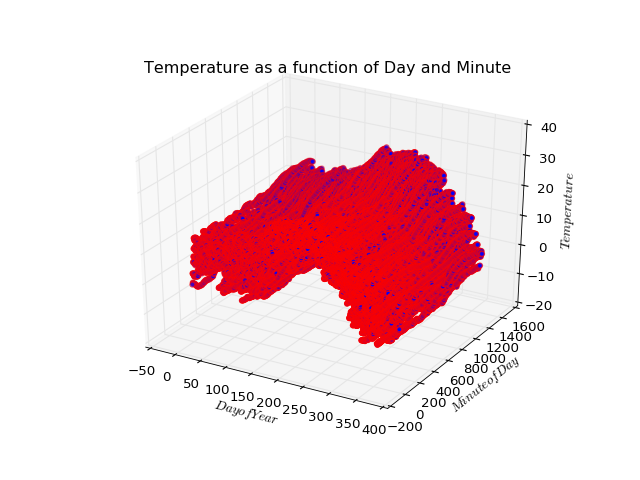

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_date_train, x_minutes_train, y_train, color = 'red')
ax.set_xlabel('$Day of Year$')
ax.set_ylabel('$Minute of Day$')
ax.set_zlabel('$Temperature$')
plt.title("Temperature as a function of Day and Minute")

### Making the model

First, let's see what we can do using only minute of the day:

In [7]:
y_train = np.asarray(y_train)

In [64]:
kernelrbf = GPy.kern.RBF(input_dim=1,lengthscale = 100)
m_mins = GPy.models.SparseGPRegression(X= x_minutes_train, Y = y_train, num_inducing = 20)
#m_mins.Z.unconstrain()
m_mins.optimize('bfgs')

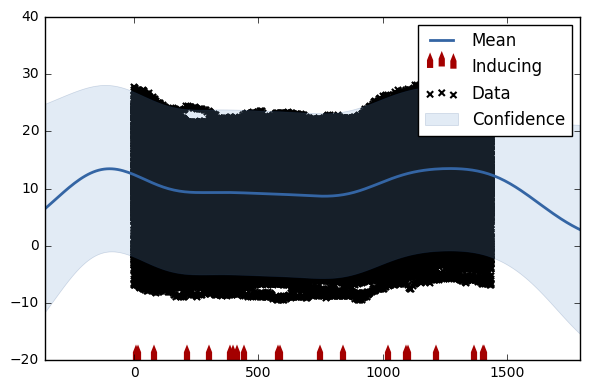

In [65]:
m_mins.plot()
plt.show()

The model can just do so much with this data. Here, the lenghtscale of the kernel was quite important. With the default lenghtscale, the model just had a mean of 0 and large confidence intervals (it didn't really learn anything). After using different values, 300 seemed appropriate for the minute of the day data. Regarding kernels, I intended to also use periodic and periodic exponential and compare how they fared against RBF. However, the GPy implementations for these other kernels were too memory consuming when using this dataset.

Now let's explore the day of year data:

In [135]:
m_date = GPy.models.SparseGPRegression(X= x_date_train, Y = y_train ,num_inducing = 1)
m_date.Z.unconstrain()
#m_date.optimize('bfgs')
m_date.optimize_restarts(num_restarts = 10)


Optimization restart 1/10, f = 332984.355995
Optimization restart 2/10, f = 418579.863609
Optimization restart 3/10, f = 418579.861628
Optimization restart 4/10, f = 418579.86344
Optimization restart 5/10, f = 418579.863579
Optimization restart 6/10, f = 418579.863618
Optimization restart 7/10, f = 332984.355995
Optimization restart 8/10, f = 355509.971146
Optimization restart 9/10, f = 418579.863629
Optimization restart 10/10, f = 418579.863507


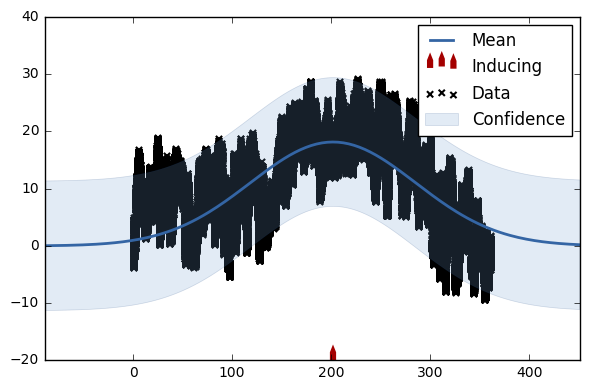

In [136]:
m_date.plot()
plt.show()

In [137]:
y_hat_train = m_date.predict(x_date_train)[0]
mse(y_hat_train,y_train)

32.64881598482495

In [138]:
y_hat_val = m_date.predict(x_date_val)[0]
mse(y_hat_val,y_val)

26.376372853672994

Using a large number of inducing points resulted in overfitting. The results above are the best I was able to obtained for this model. Below, we can see the relationship between number of inducing points and validation MSE. It is nice that the best validation accuracy was made with a single inducing point at the middle of the year, producing the simple model seen above. It was important to use optimize restarts, because the model with a single inducing point works well only when the inducing point is around day 200 (model predicts just 0s if inducing point is too close to either end). I arrived to the appropriate inducing point by leaving Z unconstrained and using multiple restarts in optimization.

In [141]:
val_mse = []
inducing_points = [i for i in range(1,8,1)]

for points in inducing_points:
    m_date = GPy.models.SparseGPRegression(X= x_date_train, Y = y_train ,num_inducing = points)
    m_date.Z.unconstrain()
    #m_date.optimize('bfgs')  
    m_date.optimize_restarts(num_restarts = 5, verbose = 0)
    y_hat_val = m_date.predict(x_date_val)[0]
    val_mse.append(mse(y_hat_val,y_val))

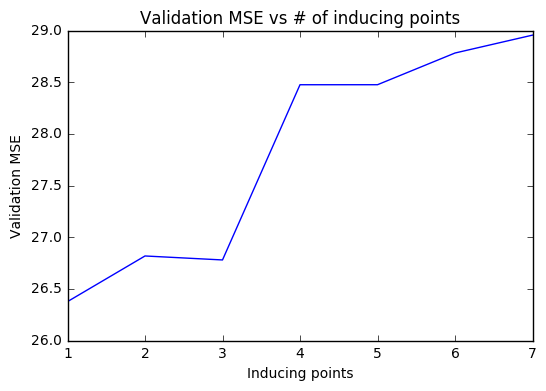

In [142]:
plt.plot(inducing_points,val_mse)
plt.xlabel("Inducing points")
plt.ylabel("Validation MSE")
plt.title("Validation MSE vs # of inducing points")
plt.show()

Now that is pretty!

## 2 dimensions

Now, let's see what we can do when we use both of our input variables.

In [10]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)

In [13]:
kernel = GPy.kern.RBF(input_dim=2, lengthscale = 100 )
m_2d = GPy.models.SparseGPRegression(X= np.asarray(X_train), Y = y_train, kernel = kernel)
m_2d.Z.unconstrain()
#m_2d.optimize('bfgs')
m_2d.optimize_restarts(num_restarts = 10, verbose = 0)

In [14]:
y_hat_train = m_2d.predict(X_train)[0]
mse(y_hat_train,y_train)

27.919574909312722

In [15]:
y_hat_val = m_2d.predict(np.asarray(X_val))[0]
mse(y_hat_val,y_val)

27.149298503056283

### Note: 

I was not able to get in time the results from te code below to cross validate the appropriate lengthscale, but the results obtained before were the best I could got for this combined model (And the results were no better than using only day of the year).

In [19]:
lengthscales = [50,100,150,200,250]
val_mse = []
for lengthscale in lengthscales:
    kernel = GPy.kern.RBF(input_dim=2, lengthscale = lengthscale )
    m_2d = GPy.models.SparseGPRegression(X= np.asarray(X_train), Y = y_train, kernel = kernel)
    m_2d.Z.unconstrain()
    m_2d.optimize_restarts(num_restarts = 5, verbose = 0)
    val_mse = []
    y_hat_val = m_2d.predict(X_val)[0]
    val_mse.append(mse(y_hat_val,y_val))

 /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/GPy/kern/src/stationary.py:331: RuntimeWarning:invalid value encountered in divide


In [ ]:
plt.plot(lengthscales,val_mse)
plt.xlabel("Length Scale")
plt.ylabel("Validation MSE")
plt.title("Validation MSE vs Length Scale")
plt.show()

## Combined Time Dimension



So far we have used time of the day and day of the year as two separate variables. However, this doesn't necessarily represent all of our knowledge in the best way. It doesn't show for example that the last minutes of one day are really close to the first minutes of the next one. Hence, we may be able to convey more information to our model with a combined metric for time. Let's try using the minute of the year (the amount of minutes that have passed in the year). This will simply be 1440 times the number of days, plus the minute of the day.

In [14]:
X_combined_train = []

for time in X_train:
    minute = time[0]
    day = time[1]    
    newtime = minute + 1440*day
    X_combined_train.append([newtime])
X_combined_train = np.asarray(X_combined_train)

In [ ]:
X_combined_val = []

for time in X_val:
    minute = time[0]
    day = time[1]    
    newtime = minute + 1440*day
    X_combined_val.append([newtime])
X_combined_val = np.asarray(X_combined_val)

In [16]:
kernelcombined = GPy.kern.RBF(input_dim=1,lengthscale=1e3)

Z  = np.asarray([[250000]])
m_combined = GPy.models.SparseGPRegression(X= X_combined_train, Y = y_train, Z=Z, 
                                           kernel = kernelcombined, num_inducing = 1)
m_combined.Z.unconstrain()
#m_combined.optimize()
m_combined.optimize_restarts(num_restarts = 2, verbose = 0)

 /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


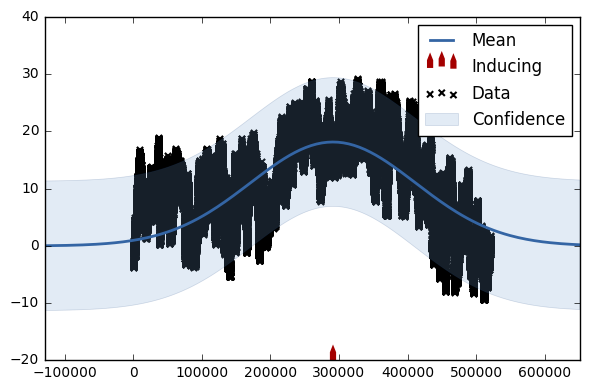

In [216]:
m_combined.plot()
plt.show()

In [217]:
y_hat_train = m_combined.predict(X_combined_train)[0]
mse(y_hat_train,y_train)

32.64623529432874

In [219]:
y_hat_val = m_combined.predict(np.asarray(X_combined_val))[0]
mse(y_hat_val,y_val)

26.377088935168572

This seems to be our best model so far (which is the same as just using day of the year). It's validation MSE of 26.38 is just slightly above that of our best linear parameter model (24.17). However, this model is quite interpretable (we can see the trend of days being hotter the closer you are to the middle of the summer). It is also quite cheap to train, given that you know beforehand that putting your single inducing point at the center is a good idea.

In [18]:
start = timeit.default_timer()

Z  = np.asarray([[250000]])
m_combined = GPy.models.SparseGPRegression(X= X_combined_train, Y = y_train, Z=Z, 
                                           kernel = kernelcombined, num_inducing = 1)
m_combined.Z.unconstrain()
m_combined.optimize()

stop = timeit.default_timer()
print "Training Time: ", stop - start 

Training Time:  0.777940034866


We can see that the graph for the combined metric looks exactly the same than for the model that uses only the day of the year (although the scale is much different now). If we attack this with an RBF like before, we will get to the same local optima of using just 1 inducing point. Hence this model will be the same as the previous one and we'll be not using all of our data. Hence, we need to use a different kernel. We need to choose a kernel such that we can show both the local periodicity within a day, and the large trend of hotter days during the summer (around day 200).

In [ ]:
kernelexp = GPy.kern.PeriodicExponential(input_dim = 1)
m_combined = GPy.models.SparseGPRegression(X= X_combined_train, Y = y_train, 
                                           kernel = kernelexp, num_inducing = 10)

m_combined.Z.unconstrain()
#m_combined.optimize()
m_combined.optimize_restarts(num_restarts = 2, verbose = 0)

The lines above crashed my notebook. Looking at my activity monitor, I noticed that this kernel results in a huge memory expense. A possibility is that this kernel forces normal GP regression (instead of sparse). Running full GP regression with an RBF seems to give the same type of memory problems. Hence, a different kernel, maybe like periodic exponential seems like something useful to portray the cyclic behavior from one day to the next, while mantaining the overal trend of the hot summer, but it seems like we can not use it well on our data.